In [0]:
!pip install -q keras

In [56]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json

token = {"username":"shreyshah2307","key":"0a50acf405130015e106547d45678259"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [0]:
!chmod 600 /content/.kaggle/kaggle.json

In [59]:
!kaggle datasets download -d kmader/finding-lungs-in-ct-data

finding-lungs-in-ct-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [61]:
!kaggle datasets download -d kmader/finding-lungs-in-ct-data

finding-lungs-in-ct-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!unzip finding-lungs-in-ct-data.zip

In [0]:
!rm -rf 3d_images

In [0]:
!rm lung_stats.csv

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

Using TensorFlow backend.


In [3]:
IMAGE_LIB = './finding-lungs-in-ct-data/2d_images/'
MASK_LIB = './finding-lungs-in-ct-data/2d_masks/'
IMG_HEIGHT, IMG_WIDTH = 32, 32
SEED=42


In [4]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.tif']

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    #im = (im - np.min(im)) / (np.max(im) - np.min(im))
    x_data[i] = im

y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(MASK_LIB + name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    y_data[i] = im

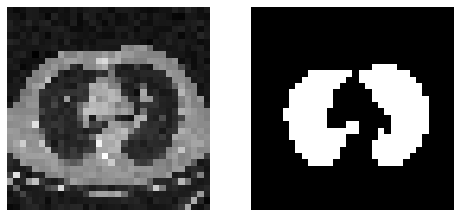

In [69]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[0].imshow(x_data[0], cmap='gray')
ax[1].imshow(y_data[0], cmap='gray')
plt.show()

In [70]:
x_data.shape

(267, 32, 32)

In [0]:
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3)

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [0]:
input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [74]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 32, 32, 8)    80          input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 16, 16, 8)    0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 16, 16, 16)   1168        max_pooling2d_7[0][0]            
__________________________________________________________________________________________________
max_poolin

In [0]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, y=None, batch_size=batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y=None, batch_size=batch_size, seed=SEED)
    while True:
        x_batch = data_generator.next()
        y_batch = mask_generator.next()
        yield x_batch, y_batch

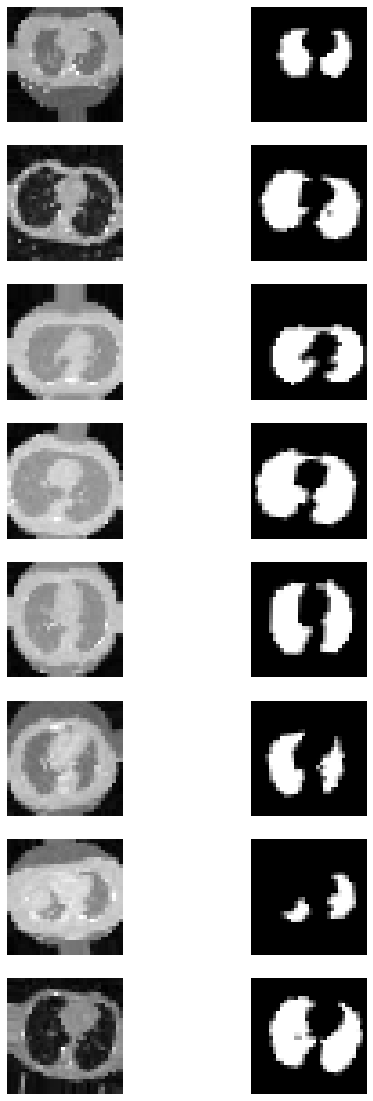

In [76]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].set_xticks([])
    ax[i,1].set_xticks([])
    ax[i,0].set_yticks([])
    ax[i,1].set_yticks([])
    ax[i,0].imshow(image_batch[i,:,:,0],cmap='gray')
    ax[i,1].imshow(mask_batch[i,:,:,0],cmap='gray')
plt.show()

In [0]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])

In [0]:
weight_saver = ModelCheckpoint('lung.h5', monitor='val_dice_coef', save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [0]:
hist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (x_test, y_test),
                           epochs=20, verbose=1,
                           callbacks = [weight_saver, annealer])

Epoch 1/20
200/200 [==============================] - 11s 54ms/step - loss: 3.9414 - dice_coef: 0.0033 - val_loss: 3.6154 - val_dice_coef: 6.7672e-11
Epoch 2/20
200/200 [==============================] - 10s 48ms/step - loss: 3.8784 - dice_coef: 4.6872e-06 - val_loss: 3.6154 - val_dice_coef: 6.7672e-11
Epoch 3/20
200/200 [==============================] - 10s 48ms/step - loss: 3.8545 - dice_coef: 3.8233e-06 - val_loss: 3.6154 - val_dice_coef: 2.3428e-10
Epoch 4/20
200/200 [==============================] - 10s 48ms/step - loss: 3.8839 - dice_coef: 4.9699e-06 - val_loss: 3.6154 - val_dice_coef: 6.7672e-11
Epoch 5/20
200/200 [==============================] - 10s 48ms/step - loss: 3.9138 - dice_coef: 1.0330e-05 - val_loss: 3.6154 - val_dice_coef: 6.7672e-11
Epoch 6/20
200/200 [==============================] - 10s 49ms/step - loss: 3.8733 - dice_coef: 1.4461e-07 - val_loss: 3.6154 - val_dice_coef: 2.3428e-10
Epoch 7/20
200/200 [==============================] - 10s 49ms/step - loss: 3.87

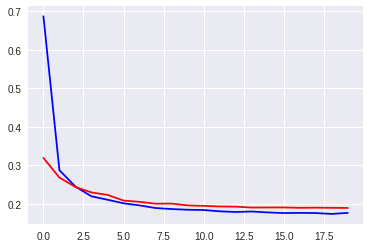

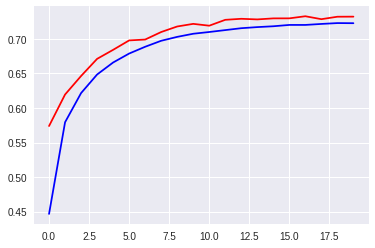

In [53]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['dice_coef'], color='b')
plt.plot(hist.history['val_dice_coef'], color='r')
plt.show()

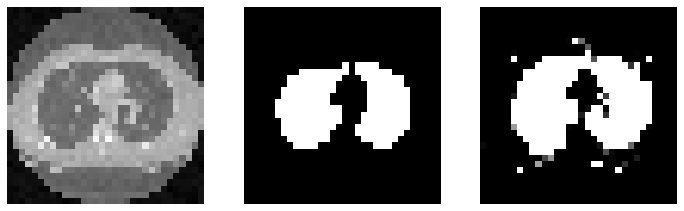

In [54]:
y_hat = model.predict(x_test)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[0].imshow(x_test[0,:,:,0], cmap='gray')
ax[1].imshow(y_test[0,:,:,0], cmap='gray')
ax[2].imshow(y_hat[0,:,:,0], cmap='gray')